### Imports

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report, f1_score,plot_confusion_matrix
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from sklearn.model_selection import StratifiedKFold,cross_val_score
from sklearn.model_selection import GridSearchCV

### Reading data

In [4]:
Training_data = pd.read_csv('train.csv', index_col=0)
Test_data = pd.read_csv('test.csv', index_col=0)
df = Training_data.copy()

### Data exploration and visualisation

##### NAN values

In [5]:
df.isna().sum()

Rooms               0
Type                0
Method              0
Distance            0
Postcode            0
Bedrooms            0
Bathroom           46
Car                53
Landsize           33
YearBuilt        4572
Lattitude           0
Longtitude          0
Regionname          0
Propertycount      40
Price class         0
dtype: int64

##### Graphical representations of the Catigorical Values

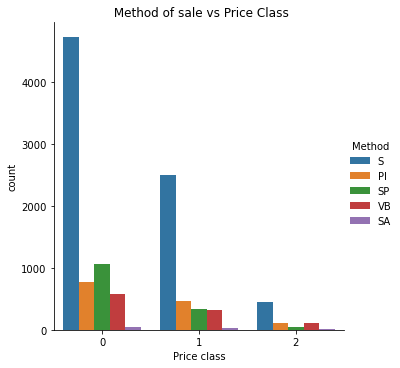

In [6]:
#Comparing the Price classes with the Methods of Sale
plt.figure(figsize =(20,10))
sns.catplot(x = "Price class",hue="Method", data=df, kind = 'count')
plt.close(1)
plt.xlabel("Price class")
plt.title(" Method of sale vs Price Class")
plt.show()


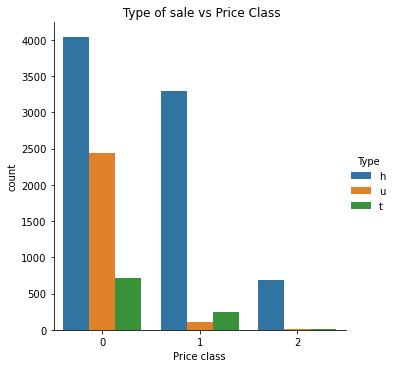

In [7]:
#Comparing the Price classes with the Methods of Sale
plt.figure(figsize =(20,10))
sns.catplot(x = "Price class",hue="Type", data=df, kind = 'count')
plt.close(1)
plt.xlabel("Price class")
plt.title(" Type of sale vs Price Class")
plt.show()


##### Checking for the class imbalances

In [8]:
df['Price class'].value_counts()

0    7189
1    3643
2     711
Name: Price class, dtype: int64

##### Heatmap

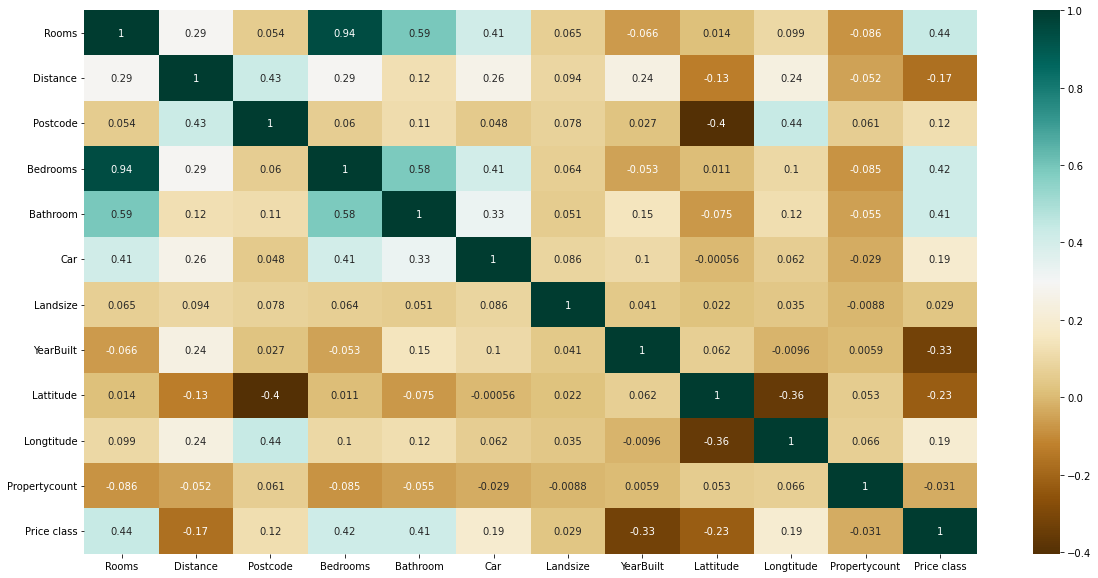

In [9]:
Numerical_columns = df.columns[df.dtypes != 'object']
corr = df[list(Numerical_columns)].corr()
plt.figure(figsize= (20,10))
sns.heatmap(corr,annot = True, cmap = 'BrBG')
plt.show()

### Data cleaning

In [10]:
# we delete the column Bedroom, Bathroom and Car for high correlation with Rooms
# We delete the yearbuilt columns because it has a lot of nan values
df = df.drop(['Bedrooms','Bathroom'], axis =1)
# Droping the NAN rows in the rest of the columns
df = df.dropna()

In [11]:
# Deleting inputs with Landsize  = 0 
df = df[df.Landsize != 0.0]

In [12]:
# We use the on hot encoding method, to reshape the cateigorical values to integers
df = pd.get_dummies(df,columns=['Type','Method','Regionname'])

### Data exploration after cleaning

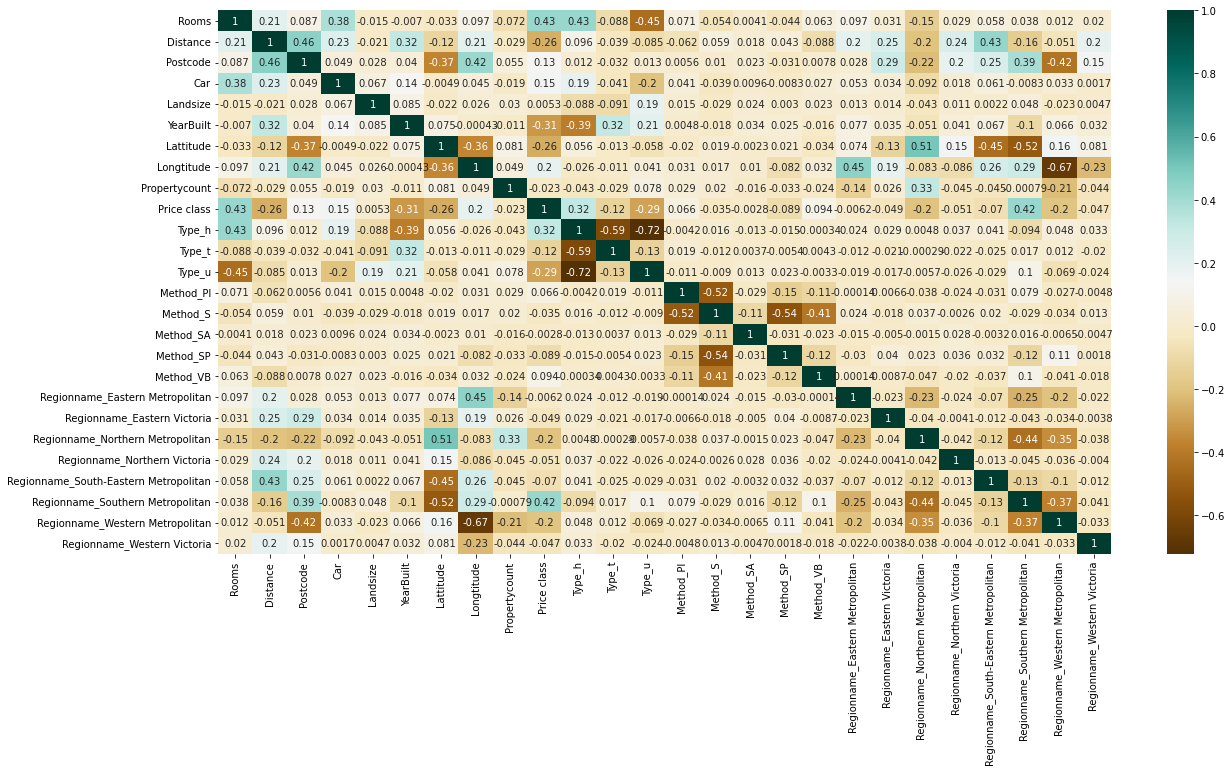

In [13]:
# We get a bigger Corr-Map due to the added columns.
Numerical_columns = df.columns[df.dtypes != 'object']
corr = df[list(Numerical_columns)].corr()
plt.figure(figsize= (20,10))
sns.heatmap(corr,annot = True, cmap = 'BrBG')
plt.show()

In [14]:
# Checking for num values
df.isna().sum()

Rooms                                    0
Distance                                 0
Postcode                                 0
Car                                      0
Landsize                                 0
YearBuilt                                0
Lattitude                                0
Longtitude                               0
Propertycount                            0
Price class                              0
Type_h                                   0
Type_t                                   0
Type_u                                   0
Method_PI                                0
Method_S                                 0
Method_SA                                0
Method_SP                                0
Method_VB                                0
Regionname_Eastern Metropolitan          0
Regionname_Eastern Victoria              0
Regionname_Northern Metropolitan         0
Regionname_Northern Victoria             0
Regionname_South-Eastern Metropolitan    0
Regionname_

### Data preprocessing

In [15]:
# Fixing the imbalances of the model using TomekLinks

tl = TomekLinks()

undersample_trainX, undersample_trainY = tl.fit_resample(df.drop('Price class', axis=1), df['Price class'])
undersample_train = pd.concat([pd.DataFrame(undersample_trainY), pd.DataFrame(undersample_trainX)], axis=1)
df = undersample_train

In [16]:
X,y = df.drop('Price class', axis = 1).copy(), df['Price class'].copy()

#### Train test split

In [17]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.4,random_state=100, stratify= y)

#### Scaling

In [18]:
sc = StandardScaler()
sc.fit(X_train)
X_train_sc = sc.transform(X_train)
X_test_sc = sc.transform(X_test)

### Modelling

#### Data pipeline with kernel

In [19]:
# We Have a Kernal in the svc pipe line
pipe_svc = make_pipeline(SVC(kernel='rbf', C=20, random_state=100))
param_range  = np.linspace(10,50,5) 
param_range2 = [0.1, 1.0]

param_grid   = [{'svc__C': param_range, 'svc__kernel': ['linear']},
                {'svc__C': param_range, 'svc__gamma': param_range2, 'svc__kernel': ['rbf']}]

gs_svc = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=10,
                  n_jobs=-1)

gs_svc = gs_svc.fit(X_train_sc, y_train)
print(gs_svc.best_score_)
print(gs_svc.best_params_)

0.8347012332812229
{'svc__C': 10.0, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}


#### Data pipeline with regularization

In [20]:
#Here we see this pipline has an L2 regularisation
pipe_lr = make_pipeline(PCA(n_components=8),LogisticRegression(random_state=1, penalty = 'l2'))

#### Other models used for Kaggle submission

In [21]:
pipe_forest = make_pipeline(RandomForestClassifier(criterion='gini',
                                        n_estimators=50, 
                                        random_state= 100,
                                        n_jobs=-1))

### Final Evaluation and confusion matrix

Train accuracy SVC: 0.93184
Test accuracy SVC: 0.82823
Train accuracy reggression: 0.76589
Test accuracy reggression: 0.74383
Train accuracy forest : 1.00000
Test accuracy forest : 0.85439
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      1829
           1       0.87      0.92      0.89       938
           2       0.93      0.83      0.87       270

    accuracy                           0.93      3037
   macro avg       0.92      0.90      0.91      3037
weighted avg       0.93      0.93      0.93      3037



/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


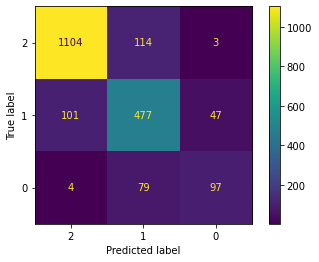

In [22]:
clf_svc = gs_svc.best_estimator_
clf_svc.fit(X_train_sc, y_train)
pipe_lr.fit(X_train_sc, y_train)
pipe_forest.fit(X_train, y_train)
pred = clf_svc.predict(X_train_sc)
clf_report = classification_report(y_train, pred)

#-----------------------------------------------------
print('Train accuracy SVC: {0:.5f}'.format(clf_svc.score(X_train_sc, y_train)))
print('Test accuracy SVC: {0:.5f}'.format(clf_svc.score(X_test_sc, y_test)))
#-----------------------------------------------------
print('Train accuracy reggression: {0:.5f}'.format(pipe_lr.score(X_train_sc, y_train)))
print('Test accuracy reggression: {0:.5f}'.format(pipe_lr.score(X_test_sc, y_test)))
#-----------------------------------------------------

print('Train accuracy forest : {0:.5f}'.format(pipe_forest.score(X_train, y_train)))
print('Test accuracy forest : {0:.5f}'.format(pipe_forest.score(X_test, y_test)))
#-----------------------------------------------------

print(clf_report)

#-----------------------------------------------------
plot_confusion_matrix(clf_svc,X_test_sc,y_test,display_labels=['2','1','0'])

